In [1]:
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("datasets/loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
df = df[["person_income", "loan_intent", "credit_score", "loan_status", "loan_percent_income"]]
df.head()

,person_income,loan_intent,credit_score,loan_status,loan_percent_income
0,71948.0,PERSONAL,561,1,0.49
1,12282.0,EDUCATION,504,0,0.08
2,12438.0,MEDICAL,635,1,0.44
3,79753.0,MEDICAL,675,1,0.44
4,66135.0,MEDICAL,586,1,0.53


In [4]:
df = pd.get_dummies(df, columns=["loan_intent"])
df.head()

,person_income,credit_score,loan_status,loan_percent_income,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,71948.0,561,1,0.49,False,False,False,False,True,False
1,12282.0,504,0,0.08,False,True,False,False,False,False
2,12438.0,635,1,0.44,False,False,False,True,False,False
3,79753.0,675,1,0.44,False,False,False,True,False,False
4,66135.0,586,1,0.53,False,False,False,True,False,False


In [5]:
df_train = df.sample(frac=0.8, random_state=42)
df_test = df.drop(df_train.index)

In [6]:
train_y = torch.tensor(df_train["loan_status"].values, dtype=torch.float32).reshape(-1, 1)
test_y = torch.tensor(df_test["loan_status"].values, dtype=torch.float32).reshape(-1, 1)

In [7]:
test_y.shape

torch.Size([9000, 1])

In [8]:
train_x = df_train.drop("loan_status", axis=1).astype("float32")
test_x = df_test.drop("loan_status", axis=1).astype("float32")

In [9]:
train_x_mean = train_x.mean()
train_x_std = train_x.std()
train_x = (train_x - train_x_mean) / train_x_std

In [10]:
test_x_mean = test_x.mean()
test_x_std = test_x.std()
test_x = (test_x - test_x_mean) / test_x_std

In [11]:
train_x.shape

(36000, 9)

In [12]:
train_x = torch.tensor(train_x.values, dtype=torch.float32)
test_x = torch.tensor(test_x.values, dtype=torch.float32)

In [13]:
train_x.shape, test_x.shape

(torch.Size([36000, 9]), torch.Size([9000, 9]))

In [14]:
model = nn.Sequential(
    nn.Linear(9, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

In [15]:
print(model)

Sequential(
  (0): Linear(in_features=9, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [16]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [17]:
total_samples = 36000
batch_size = 512

In [18]:
losses = []
for epoch in tqdm(range(1000)):
    total_loss = 0
    for i in range(0, len(train_x), batch_size):
    #for start in range(0, total_samples, batch_size):
        #end = min(total_samples, start + batch_size)
        #X_batch = train_x[start:end]
        #y_batch = train_y[start:end]
        X_batch = train_x[i: i+ batch_size]
        y_batch = train_y[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)        
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    # if i % 10 ==0:
    #     print(total_loss)
    if epoch % 100 == 0:
        losses.append(loss.item())

100%|██████████████████| 1000/1000 [07:06<00:00,  2.34it/s]


In [19]:
model.eval()
with torch.no_grad():
    y_pred = model(test_x)
    y_pred = nn.functional.sigmoid(y_pred) > 0.5
    y_pred = y_pred.reshape(-1, 1)
    accuracy = (y_pred == test_y).type(torch.float32).mean() 
    print(f"Final Accuracy is {accuracy.item()}")

Final Accuracy is 0.8338888883590698


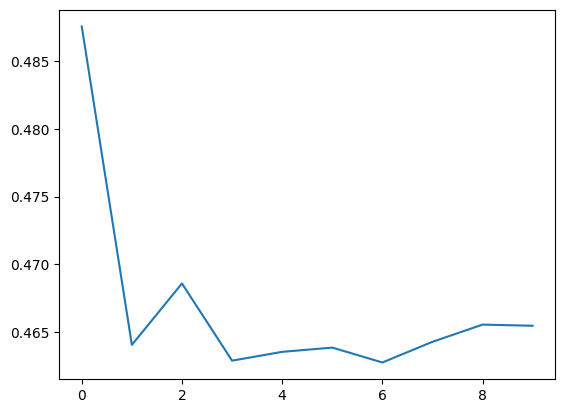

In [20]:
plt.plot(losses)

In [21]:
losses

[0.48753172159194946,
 0.46407443284988403,
 0.4685981869697571,
 0.4629126489162445,
 0.46356096863746643,
 0.4638739228248596,
 0.46277761459350586,
 0.4643006920814514,
 0.4655665457248688,
 0.4654828906059265]